In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime

from tqdm.notebook import tqdm

%matplotlib notebook

In [2]:
def parse_gpustat_file(path, num_gpus):
    gpus = [str(i) for i in range(num_gpus)]
    data = [[] for i in range(num_gpus)]
    times = []
    with open(path, "r") as f:
        for i, line in enumerate(f):
            
            if line[0] == "[" and line[1] in gpus:
                gpu_id = int(line[1])
                gpu_util = int(line.split()[5])
                data[gpu_id].append(gpu_util)
            elif "470.103.01" in line:
                line = " ".join(line.split()[1:-1])
                struct = time.strptime(line, "%a %b %d %H:%M:%S %Y")
                timestamp = datetime.fromtimestamp(time.mktime(struct))
                times.append(timestamp)
    
    data = {f"gpu:{i}":gpu_i_data for i, gpu_i_data in enumerate(data)}
    data["timestamp"] =  pd.to_datetime(times)
    df = pd.DataFrame(data)
    return df

In [41]:
# exp_dir = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/polaris/candle/output/"
# # exp_name = "candle_combo-DBOS4M-async-RF-qUCB-qUCB-256-4-10800-42"
# # exp_name = "candle_combo-DBO-sync-RF-qUCB-qUCB-128-4-10800-42"
# # exp_name = "candle_combo-DBOS4M-async-RF-qUCB-qUCB-128-4-10800-42"
# # exp_name = "candle_combo-CBO-async-RF-qUCB-qUCB-128-4-10800-42"
# # exp_name = "candle_combo-CBO-async-GP-UCB-cl_max-128-4-10800-42"
# exp_name = "candle_combo-CBO-async-DUMMY-UCB-cl_max-128-4-10800-42"

exp_dir = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/polaris/dhb/output/"
# exp_name = "dhb_combo-TPESHA-async-RF-qUCB-qUCB-4-4-3600-42"
# exp_name = "dhb_combo-DBOS4MSHA-async-RF-qUCB-qUCB-4-4-3600-42"
# exp_name = "dhb_combo-DBOS4M-async-RF-qUCB-qUCB-4-4-3600-42"
exp_name = "dhb_combo-DBOS4MSHA-async-MF-qUCB-qUCB-4-4-3600-42"


path = os.path.join(exp_dir, exp_name)

data = []
for fname in tqdm(os.listdir(path)):
    if "gpu" in fname:
        node_id = int(fname.split(".")[1])
        if node_id % 4 == 0:
            gpustat_file_path = os.path.join(path, fname)
            df = parse_gpustat_file(gpustat_file_path, num_gpus=4)
            df["node"] = node_id // 4
            data.append(df)

df = pd.concat(data, axis=0).reset_index(drop=True)
df

  0%|          | 0/24 [00:00<?, ?it/s]

,gpu:0,gpu:1,gpu:2,gpu:3,timestamp,node
0,0,0,0,0,2022-10-19 17:34:02,0
1,0,0,0,0,2022-10-19 17:34:03,0
2,0,0,0,0,2022-10-19 17:34:04,0
3,0,0,0,0,2022-10-19 17:34:05,0
4,0,0,0,0,2022-10-19 17:34:06,0
...,...,...,...,...,...,...
3588,50,49,42,48,2022-10-19 18:33:53,0
3589,49,48,40,48,2022-10-19 18:33:54,0
3590,47,49,33,36,2022-10-19 18:33:55,0
3591,50,47,42,36,2022-10-19 18:33:56,0


In [42]:
tdelta = pd.Timedelta(15, "seconds")
ngpus = len(np.unique(df.node)) * 4
print(f"{ngpus=}")

tmin, tmax = df["timestamp"].min(), df["timestamp"].max()
t = tmin
utilization = []
times = []
while t < tmax:
    selection = (t <= df["timestamp"]) & (df["timestamp"]< t + tdelta)
    times.append(t)
    df_sel = df[selection]
    res = df[selection].groupby("node").mean()
    res = res.values.reshape(-1)
    if res.shape[0] == ngpus:
        utilization.append(res)
    t += tdelta

utilization = np.array(utilization)
utilization.shape

ngpus=4


(240, 4)

<IPython.core.display.Javascript object>


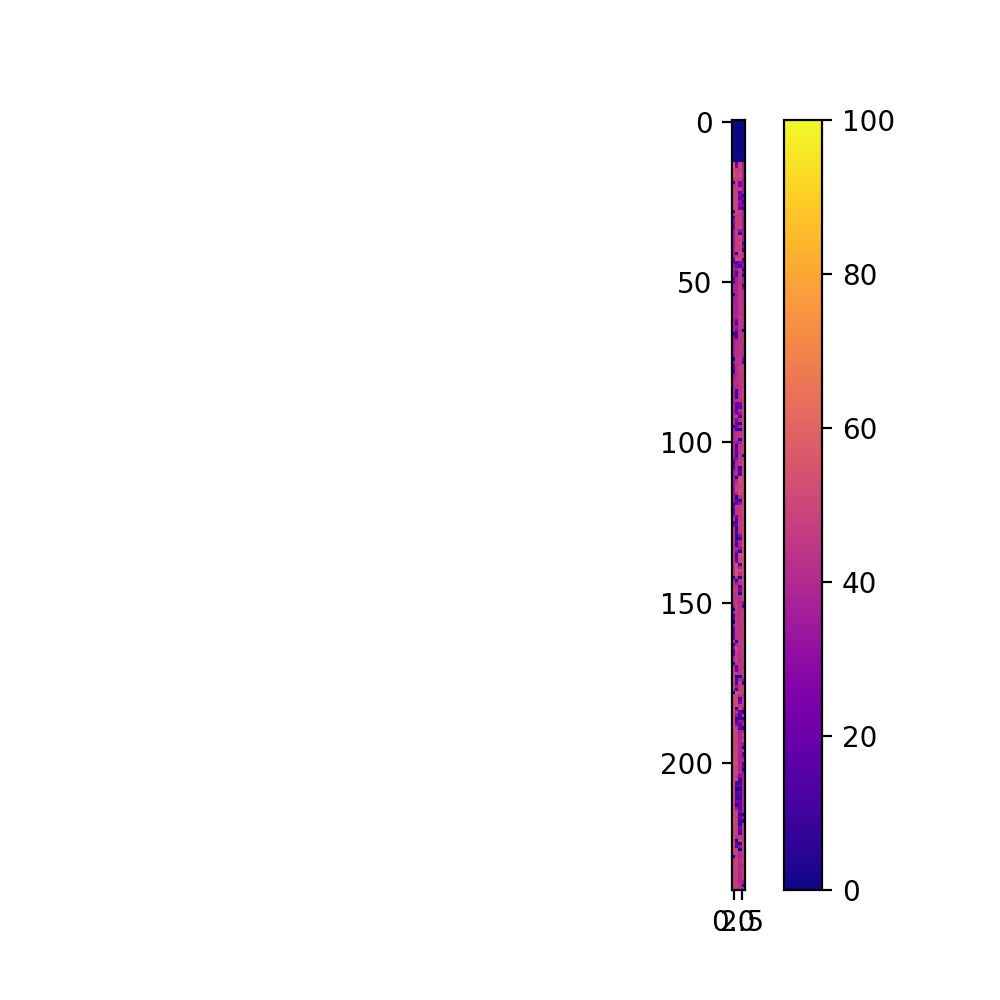

In [43]:
plt.figure(figsize=(5, 5))
plt.imshow(np.asarray(utilization), cmap="plasma", vmin=0, vmax=100)
plt.colorbar()
plt.show()

In [44]:
data = np.asarray(utilization)

mean_util = data.mean(axis=1)
std_util = data.std(axis=1)
x0 = times[0].timestamp()
x = [t.timestamp() - x0 for t in times]

<IPython.core.display.Javascript object>


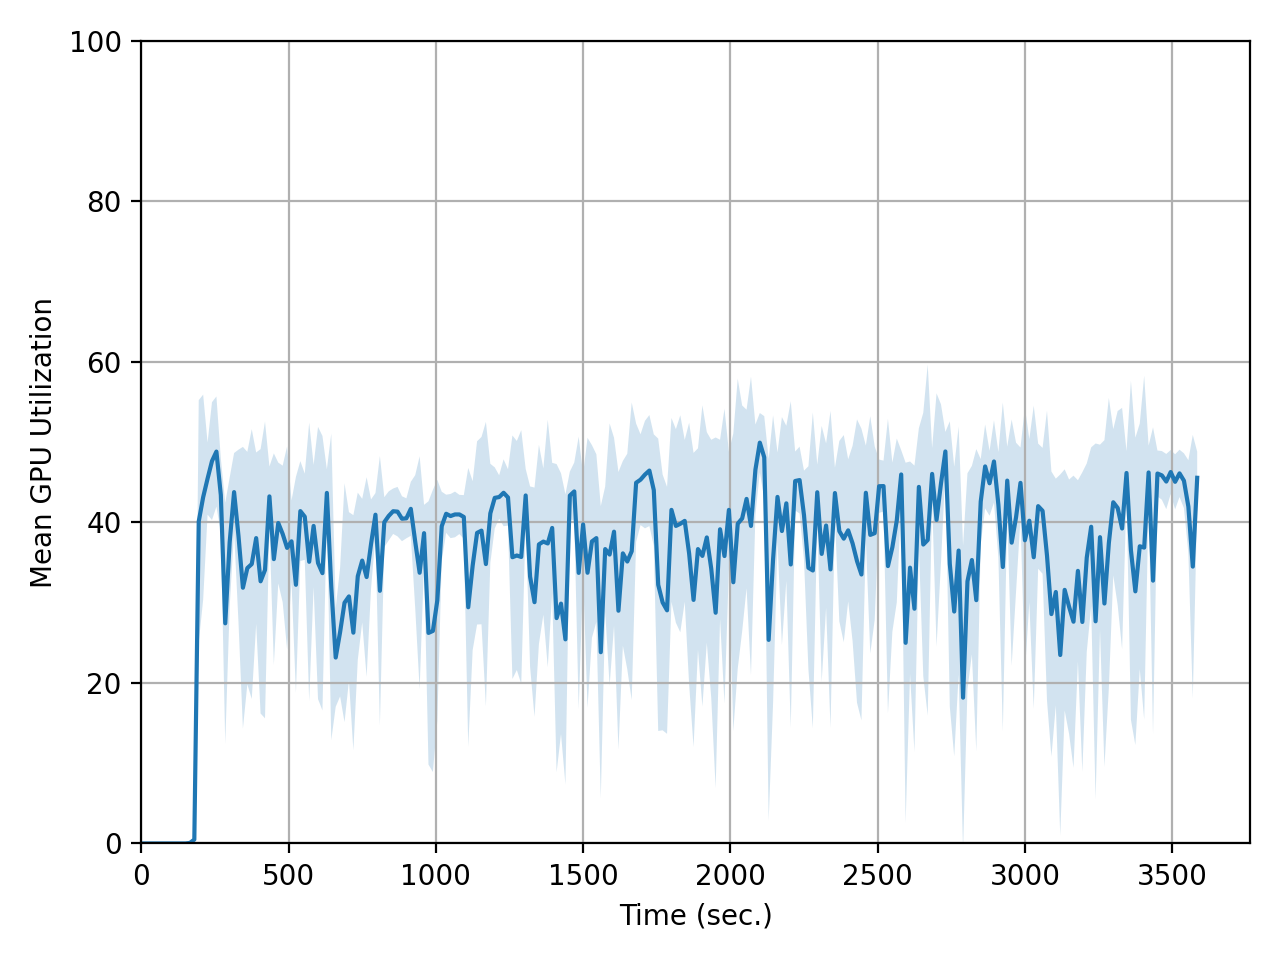

In [45]:
plt.figure()
plt.plot(x, mean_util)
plt.fill_between(x, y1=mean_util+std_util, y2=mean_util-std_util, alpha=0.2)
plt.ylabel("Mean GPU Utilization")
plt.xlabel("Time (sec.)")
plt.xlim(0)
plt.ylim(0, 100)
plt.grid()
plt.tight_layout()
plt.savefig(f"gpu-utilization/{exp_name}.pdf")
plt.show()

1665766934.0